# Obtendo e processando imagens de cada incêndio

Este notebook implementa o **processamento de teste das imagens Sentinel-2 para cada incêndio selecionado** a partir do arquivo `coordenadas_e_informacoes_cenas_usadas.csv` (gerado no notebook anterior).  
O foco aqui é:

- baixar as bandas das cenas **pré-fogo** e **pós-fogo** para um incêndio específico;
- gerar composições RGB e **índices espectrais** (NDVI, NBR e NBRSWIR);
- calcular a **diferença dos índices pré vs. pós-fogo** para destacar a área queimada;
- salvar esses vetores de diferença em disco para uso posterior nas etapas de **segmentação**.

De forma resumida, o fluxo é:

1. **Importação de bibliotecas e leitura do CSV de cenas**
   - Carrega bibliotecas de geoprocessamento, imagens e plots (`geopandas`, `pandas`, `numpy`, `rasterio`, `matplotlib`, `pystac_client`, etc.).
   - Lê o arquivo  
     `Imagens_e_indices/coordenadas_e_informacoes_cenas_usadas.csv`,  
     que contém:
     - `bbox` (janela espacial do incêndio),
     - IDs das imagens **pré** e **pós** (`pre_id`, `post_id`),
     - datas de aquisição (`pre_datetime`, `post_datetime`),
     - FRP, risco de fogo e outras informações do cluster de focos.

2. **Seleção de um incêndio (linha do DataFrame)**
   - Define o índice `linha` e extrai a linha correspondente de `df_final_images`.
   - A partir dessa linha, obtém:
     - a **bounding box** do incêndio;
     - as datas das cenas pré e pós;
     - os IDs das imagens Sentinel-2 que serão processadas.

3. **Conexão ao STAC do BDC/INPE e recuperação das cenas**
   - Abre o catálogo STAC do BDC:  
     `https://data.inpe.br/bdc/stac/v1/`
   - Usa a coleção `S2_L2A-1`.
   - Localiza, no catálogo, os itens correspondentes aos IDs **pré** e **pós-fogo**.
   - Para cada item, extrai os links das bandas necessárias e prepara a **janela espacial** de leitura (`bbox`) usando `rasterio.windows.from_bounds`.

4. **Leitura das bandas e ajuste de resolução**
   - Lê, para cada cena (pré e pós), as bandas relevantes do Sentinel-2, por exemplo:
     - Bandas de 10 m (RGB/NI): `B04` (red), `B03` (green), `B02` (blue), `B08` (NIR);
     - Bandas de 20 m (SWIR): `B8A`, `B11`, `B12`.
   - Utiliza a função `reproject_to_ref` para **reprojetar e reamostrar as bandas de 20 m** para a mesma grade da banda de referência (10 m), garantindo:
     - mesmo sistema de coordenadas,
     - mesmo `transform` espacial,
     - mesma forma (altura × largura).

5. **Criação de composições RGB e visualização básica**
   - Constrói uma composição **RGB** (por exemplo, usando `B04`, `B03`, `B02`) para as cenas pré e pós.
   - Plota, lado a lado:
     - **imagem pré-fogo** na esquerda;
     - **imagem pós-fogo** na direita;
     - com títulos contendo a data e uma breve descrição da região.
   - Esses plots servem como **verificação visual** da área de estudo.

6. **Cálculo dos índices espectrais (pré e pós-fogo)**
   - Define funções para os índices:
     - **NDVI** = (B08 − B04) / (B08 + B04)
     - **NBR**  = (B8A − B12) / (B8A + B12)
     - **NBRSWIR** = (B12 − B11 − 0.02) / (B12 + B11 + 0.1)
   - Calcula, separadamente, para cada cena:
     - `ndvi_pre`, `nbr_pre`, `nbrswir_pre` (antes do fogo);
     - `ndvi_pos`, `nbr_pos`, `nbrswir_pos` (depois do fogo).
   - Gera plots básicos de cada índice **pré vs. pós**, com a mesma escala de cores, para facilitar a comparação visual.

7. **Detecção da área queimada via diferença de índices**
   - Calcula a **diferença relativa** dos índices entre pré e pós-fogo:
     - `ndvi_dif = ndvi_pre − ndvi_pos`
     - `nbr_dif  = nbr_pre  − nbr_pos`
     - `nbrswir_dif = nbrswir_pre − nbrswir_pos`
   - Essas diferenças ressaltam as mudanças espectrais associadas ao incêndio, em especial:
     - quedas de NDVI (perda de vegetação);
     - variações em NBR e NBRSWIR ligadas à presença de área queimada.
   - Plota os mapas de diferença, permitindo localizar visualmente as regiões com maior impacto do fogo.

8. **Salvamento dos vetores de diferença para uso posterior**
   - Ao final, agrupa os arrays de diferença (`ndvi_dif`, `nbr_dif`, `nbrswir_dif`) e salva em um arquivo **compactado** (`.npz`) na pasta `Imagens_e_indices`, com nome atrelado ao índice da imagem (`linha`).
   - Exemplo:  
     - salvando: `np.savez_compressed(..., diff_ndvi=ndvi_dif, diff_nbr=nbr_dif, diff_nbrswir=nbrswir_dif)`  
     - carregando depois: `data = np.load(...); diff_ndvi = data["diff_ndvi"]; ...`
   - Esses arquivos `.npz` servem como **entrada padronizada** para os próximos notebooks, onde serão aplicados os métodos de **segmentação (K-means, FCM, QFFCM, etc.)** sobre as diferenças de índices.

---

Em resumo, este notebook pega um incêndio específico já selecionado no CSV, baixa as cenas Sentinel-2 pré e pós-fogo, calcula e visualiza os **índices espectrais** e suas **diferenças**, e gera arquivos compactados com esses vetores de diferença. Esses produtos são a base quantitativa para as próximas etapas de **detecção e segmentação automática de áreas queimadas**.


## Bibliotecas usadas:

In [ ]:
import geopandas as gpd
import pandas as pd
import os
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import Image

from shapely.geometry import box
#import folium
import warnings
warnings.filterwarnings("ignore")

import rasterio
from rasterio import Affine
from rasterio.crs import CRS
#import rasterio.transform
from rasterio.windows import from_bounds
from rasterio.warp import Resampling, reproject, transform

import ast
import pandas as pd
import pystac_client

import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling


## Importando arquivo com informações sobre as imagens Selecionadas:

In [ ]:
df_final_images = pd.read_csv("Imagens_e_indices/coordenadas_e_informacoes_cenas_usadas.csv", index_col=0)

## Encontrando as imagens no catalogo STAC : 

In [ ]:
# Escolhendo imagem(Nesse caso a primeira)---

linha = 0
row = df_final_images.iloc[linha]
print(row)                                   # Visualizar linha específica


cluster_date                                                                      2024-08-03
region_key                                          BBOX:-51.0002,-12.7524,-49.9887,-11.7577
bbox                                       [-50.680715764205985, -12.156412210162701, -50...
frp_median                                                                             104.3
risco_mean                                                                          0.998364
pre_id                                     S2A_MSIL2A_20240723T133841_N0511_R124_T22LEM_2...
pre_datetime                                                       2024-07-23 13:38:41+00:00
pre_cloud                                                                           0.001765
post_id                                    S2A_MSIL2A_20240812T133841_N0511_R124_T22LEM_2...
post_datetime                                                      2024-08-12 13:38:41+00:00
post_cloud                                                            

In [8]:

# Conecta ao STAC
servico   = "https://data.inpe.br/bdc/stac/v1/"
catalogo  = pystac_client.Client.open(servico)

# Coleção (ajuste se for outra)
COLLECTION = "S2_L2A-1"

# --- 1) Monta o bbox (a linha é string tipo '[-50.3, -11.99, ...]')---  Esse passo monta a janela espacial de busca
bbox_val = row["bbox"]
bbox = ast.literal_eval(bbox_val) if isinstance(bbox_val, str) else bbox_val  # vira lista [minLon, minLat, maxLon, maxLat]

# --- 2) Monta o range de datas a partir das colunas pre_datetime e post_datetime ---
pre_dt  = pd.to_datetime(row["pre_datetime"], utc=True, errors="coerce")
post_dt = pd.to_datetime(row["post_datetime"], utc=True, errors="coerce")
if pd.isna(pre_dt) or pd.isna(post_dt):
    raise ValueError("Datas inválidas em pre_datetime/post_datetime para a última linha.")

# ISO 8601 com 'Z'
pre_iso  = pre_dt.isoformat().replace("+00:00", "Z")
post_iso = post_dt.isoformat().replace("+00:00", "Z")
date_range = f"{pre_iso}/{post_iso}"

# --- 3) Busca STAC apenas para esse bbox+intervalo de data---
item_search = catalogo.search(
    bbox=bbox,
    collections=[COLLECTION],
    datetime=date_range,
    max_items=200  # opcional: limita pra não trazer demais
)

items = list(item_search.item_collection())


# Ordenar os itens por data (crescente: menor para maior) - etapa opcional
items = sorted(items, key=lambda x: x.datetime)


In [9]:
for i, item in enumerate(items):
    item_id = item.id  # ID do item para identificação

    date = item.properties.get('datetime', 'N/A')  # Data da aquisição
    
    cloud_cover = item.properties.get('eo:cloud_cover', 'N/A')  # Obtém a cobertura de nuvens

    tile_id = item.properties.get('tileId', 'N/A')  # Obtém o ID do tile

        
    print(f"Imagem [{i}]: {item_id}, Data: {date}, Cobertura de nuvens: {cloud_cover:.1f}% , Tile_ID: {tile_id}")

Imagem [0]: S2A_MSIL2A_20240723T133841_N0511_R124_T22LEM_20240723T210210, Data: 2024-07-23T13:38:41.000000Z, Cobertura de nuvens: 0.0% , Tile_ID: 22LEM
Imagem [1]: S2B_MSIL2A_20240728T133839_N0511_R124_T22LEM_20240728T155417, Data: 2024-07-28T13:38:39.000000Z, Cobertura de nuvens: 0.0% , Tile_ID: 22LEM
Imagem [2]: S2B_MSIL2A_20240807T133839_N0511_R124_T22LEM_20240807T172418, Data: 2024-08-07T13:38:39.000000Z, Cobertura de nuvens: 0.0% , Tile_ID: 22LEM
Imagem [3]: S2A_MSIL2A_20240812T133841_N0511_R124_T22LEM_20240812T183146, Data: 2024-08-12T13:38:41.000000Z, Cobertura de nuvens: 0.0% , Tile_ID: 22LEM
Imagem [4]: S2A_MSIL2A_20240812T133841_N0511_R124_T22LEM_20240812T202057, Data: 2024-08-12T13:38:41.000000Z, Cobertura de nuvens: 0.0% , Tile_ID: 22LEM


### Escolhendo a imagem pré e pós:

In [10]:
next((i for i, item in enumerate(items) if item.id == row["pre_id"]), None)

0

In [11]:
imagem_pre_escolhida = items[next((i for i, item in enumerate(items) if item.id == row["pre_id"]), None)]
imagem_pos_escolhida = items[next((i for i, item in enumerate(items) if item.id == row["post_id"]), None)]

In [12]:
imagem_pre = imagem_pre_escolhida.assets
imagem_pos = imagem_pos_escolhida.assets

### Visualizando Snapshot das imagens:

In [13]:
from IPython.display import display, HTML

# Dados dos thumbnails
thumbnail_pre = imagem_pre['PVI']
thumbnail_pos = imagem_pos['PVI']

# Datas e títulos
data_pre = items[0].properties.get('datetime', 'N/A')[:10]
data_pos = items[-2].properties.get('datetime', 'N/A')[:10]

titulo_pre = f"Imagem pré-fogo - data: {data_pre}"
titulo_pos = f"Imagem pós-fogo - data: {data_pos}"

# HTML com títulos e imagens lado a lado
html_code = f"""
<div style="display: flex; align-items: flex-start;">
    <div style="text-align: center; margin-right: 20px;">
        <div style="font-weight: bold; margin-bottom: 5px;">{titulo_pre}</div>
        <img src="{thumbnail_pre.href}">
    </div>
    <div style="text-align: center;">
        <div style="font-weight: bold; margin-bottom: 5px;">{titulo_pos}</div>
        <img src="{thumbnail_pos.href}">
    </div>
</div>
"""

display(HTML(html_code))

## Realizando aumento da Resolução para observar pontos específicos das imagens:

### Função pra leitura das bandas nas imagens pré o pós:

In [16]:
def read(uri: str, bbox: list, masked: bool = True, crs: str = None):
    """Lê uma janela raster como numpy.ma.masked_array."""
    source_crs = CRS.from_string('EPSG:4326')
    
    if crs:
        source_crs = CRS.from_string(crs)

    w, s, e, n = bbox  # Pegando as coordenadas do bbox
        
    with rasterio.open(uri) as dataset:
        transformer = transform(source_crs, dataset.crs, [w, e], [s, n])
        window = from_bounds(transformer[0][0], transformer[1][0], 
                             transformer[0][1], transformer[1][1], dataset.transform)
        
        box_trasform = rasterio.transform.from_bounds(transformer[0][0], transformer[1][0],
                                                      transformer[0][1], transformer[1][1], window.width, window.height)
        
        return dataset.read(1, window=window, masked=masked)*0.0001, box_trasform

### Realizando a composição da imagem utilizando (Carregando diversas bandas espectrais):

#### Função que faz o redimensionamento de resolução e lê as bandas:

In [17]:
def reproject_to_ref(src_arr, src_transform, src_crs,
                     ref_transform, ref_crs, ref_shape,
                     resampling=Resampling.bilinear,
                     src_nodata=0, dst_nodata=0):
    """
    Reprojeta um array 2D (H, W) para a grade de referência (ref_transform/crs/shape).
    Garante que src_arr não seja MaskedArray.
    """
    # Garante ndarray 2D (preenche máscaras) e tipo consistente
    if np.ma.isMaskedArray(src_arr):
        src = np.ma.filled(src_arr, src_nodata)
    else:
        src = src_arr
    src = np.asarray(src).astype(np.float32)

    # Destination 2D com shape da referência
    dst = np.full(ref_shape, dst_nodata, dtype=src.dtype)

    reproject(
        source=src,
        destination=dst,
        src_transform=src_transform,
        src_crs=src_crs,
        dst_transform=ref_transform,
        dst_crs=ref_crs,
        src_nodata=src_nodata,
        dst_nodata=dst_nodata,
        resampling=resampling,
    )
    return dst

# ---- Ler dados (sua função read deve retornar array 2D e o transform) ----
b02_pre, t02_pre = read(imagem_pre['B02'].href, bbox=bbox) # Blue
b03_pre, t03_pre = read(imagem_pre['B03'].href, bbox=bbox) # Green
b04_pre, t04_pre = read(imagem_pre['B04'].href, bbox=bbox) # Red
b08_pre, t08_pre = read(imagem_pre['B08'].href, bbox=bbox) # NIR
b8A_pre, t8A_pre = read(imagem_pre['B8A'].href, bbox=bbox) # Narrow NIR
b11_pre, t11_pre = read(imagem_pre['B11'].href, bbox=bbox) # SWIR1
b12_pre, t12_pre = read(imagem_pre['B12'].href, bbox=bbox) # SWIR2

# CRS de cada banda (fonte).
with rasterio.open(imagem_pre['B02'].href) as ds: crs_b02 = ds.crs
with rasterio.open(imagem_pre['B03'].href) as ds: crs_b03 = ds.crs
with rasterio.open(imagem_pre['B04'].href) as ds: crs_b04 = ds.crs
with rasterio.open(imagem_pre['B08'].href) as ds: crs_b08 = ds.crs
with rasterio.open(imagem_pre['B8A'].href) as ds: crs_b8A = ds.crs
with rasterio.open(imagem_pre['B11'].href) as ds: crs_b11 = ds.crs
with rasterio.open(imagem_pre['B12'].href) as ds: crs_b12 = ds.crs  # ref_crs

# ---- Defina a grade de referência pela B12 pré (20 m) ----
ref_transform = t12_pre
ref_crs = crs_b12
ref_shape = b12_pre.shape  # (H, W)

# ---- Reprojetar PRÉ para a grade de referência ----
b02_pre_m = reproject_to_ref(b02_pre, t02_pre, crs_b02, ref_transform, ref_crs, ref_shape, Resampling.bilinear)
b03_pre_m = reproject_to_ref(b03_pre, t03_pre, crs_b03, ref_transform, ref_crs, ref_shape, Resampling.bilinear)
b04_pre_m = reproject_to_ref(b04_pre, t04_pre, crs_b04, ref_transform, ref_crs, ref_shape, Resampling.bilinear)
b08_pre_m = reproject_to_ref(b08_pre, t08_pre, crs_b08, ref_transform, ref_crs, ref_shape, Resampling.bilinear)
b8A_pre_m = reproject_to_ref(b8A_pre, t8A_pre, crs_b8A, ref_transform, ref_crs, ref_shape, Resampling.bilinear)
b11_pre_m = reproject_to_ref(b11_pre, t11_pre, crs_b11, ref_transform, ref_crs, ref_shape, Resampling.bilinear)
b12_pre_m = np.asarray(np.ma.filled(b12_pre, 0)).astype(np.float32)  # já está na grade ref

# ---- Ler POS-fogo ----
b02_pos, t02_pos = read(imagem_pos['B02'].href, bbox=bbox) # Blue
b03_pos, t03_pos = read(imagem_pos['B03'].href, bbox=bbox) # Green
b04_pos, t04_pos = read(imagem_pos['B04'].href, bbox=bbox) # Red
b08_pos, t08_pos = read(imagem_pos['B08'].href, bbox=bbox) # NIR
b8A_pos, t8A_pos = read(imagem_pos['B8A'].href, bbox=bbox) # Narrow NIR
b11_pos, t11_pos = read(imagem_pos['B11'].href, bbox=bbox) # SWIR1
b12_pos, t12_pos = read(imagem_pos['B12'].href, bbox=bbox) # SWIR2

# CRS de cada banda (fonte)
with rasterio.open(imagem_pos['B02'].href) as ds: crs_b02p = ds.crs
with rasterio.open(imagem_pos['B03'].href) as ds: crs_b03p = ds.crs
with rasterio.open(imagem_pos['B04'].href) as ds: crs_b04p = ds.crs
with rasterio.open(imagem_pos['B08'].href) as ds: crs_b08p = ds.crs
with rasterio.open(imagem_pos['B8A'].href) as ds: crs_b8Ap = ds.crs
with rasterio.open(imagem_pos['B11'].href) as ds: crs_b11p = ds.crs
with rasterio.open(imagem_pos['B12'].href) as ds: crs_b12p = ds.crs  # pode ser igual ao ref_crs; se diferente, reproject lida

# ---- Reprojetar POS para a mesma grade de referência ----
b02_pos_m = reproject_to_ref(b02_pos, t02_pos, crs_b02p, ref_transform, ref_crs, ref_shape, Resampling.bilinear)
b03_pos_m = reproject_to_ref(b03_pos, t03_pos, crs_b03p, ref_transform, ref_crs, ref_shape, Resampling.bilinear)
b04_pos_m = reproject_to_ref(b04_pos, t04_pos, crs_b04p, ref_transform, ref_crs, ref_shape, Resampling.bilinear)
b08_pos_m = reproject_to_ref(b08_pos, t08_pos, crs_b08p, ref_transform, ref_crs, ref_shape, Resampling.bilinear)
b8A_pos_m = reproject_to_ref(b8A_pos, t8A_pos, crs_b8Ap, ref_transform, ref_crs, ref_shape, Resampling.bilinear)
b11_pos_m = reproject_to_ref(b11_pos, t11_pos, crs_b11p, ref_transform, ref_crs, ref_shape, Resampling.bilinear)
b12_pos_m = reproject_to_ref(b12_pos, t12_pos, crs_b12p, ref_transform, ref_crs, ref_shape, Resampling.bilinear)

# ---- Agora todos têm exatamente o mesmo shape -> dstack funciona ;)
rgb_pre = np.dstack([b12_pre_m, b08_pre_m, b03_pre_m]) # Nesse caso não é RGB tradicional, é SWIR/NIR/GREEN
rgb_pos = np.dstack([b12_pos_m, b08_pos_m, b03_pos_m]) # Nesse caso não é RGB tradicional, é SWIR/NIR/GREEN(Escolhido para melhor visualização de áreas queimadas)


### Plot Básico
<hr style="border:1px solid #e69627;">

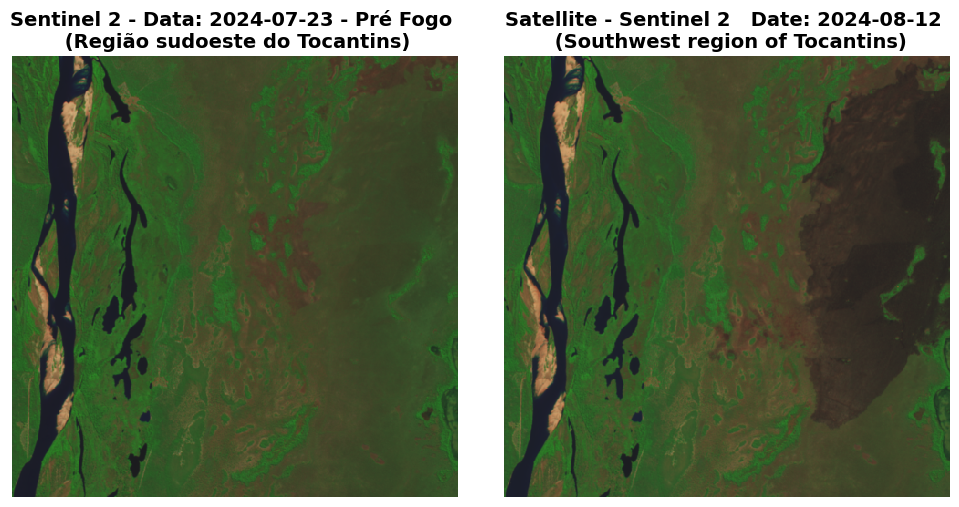

In [18]:
# Cria a figura e dois subplots lado a lado (1 linha, 2 colunas)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Primeira imagem: Pré-fogo
axes[0].set_title(
    f"Sentinel 2 - Data: {data_pre} - Pré Fogo \n (Região sudoeste do Tocantins)",
    fontsize=14, fontweight='bold'
)
axes[0].axis('off')
axes[0].imshow((rgb_pre*255).astype(np.uint8), interpolation='nearest')

# Segunda imagem: Pós-fogo
axes[1].set_title(
    f"Satellite - Sentinel 2   Date: {data_pos} \n (Southwest region of Tocantins)",
    fontsize=14, fontweight='bold'
)
axes[1].axis('off')
axes[1].imshow((rgb_pos*255).astype(np.uint8), interpolation='nearest')

# Ajusta o layout para evitar sobreposição
plt.tight_layout()
plt.show()


## Calculando os índices espectrais NDVI, NBR e NBRSWIR

In [21]:
# Geração do Índice NDVI - Exemplo com bandas específicas do Sentinel
# NDVI = (B08 - B04) / (B08 + B04)

def ndvi(b08,b04):
    ndvi=(b08-b04)/(b08+b04)
    return ndvi

# Geração do Índice NBR
# NBR = (B08 - B12) / (B08 + B12)

def nbr(b8A,b12):
    nbr=(b8A-b12)/(b8A+b12)
    return nbr

# Geração do Índice NBRSWIR (Normalized Burn Ratio-SWIR)
# NBRSWIR = (B12 − B11 − 0.02)/( B12 + B11 + 0.1)

def nbrswir(b12,b11):
    nbrswir = (b12 - b11 - 0.02)/(b12 + b11 + 0.1)
    return nbrswir

### Cálculo dos índices espectrais das imagens pré-fogo e pós-fogo

In [22]:
# calculo dos indices pré fogo
ndvi_pre = ndvi(b08_pre,b04_pre)
nbr_pre = nbr(b8A_pre,b12_pre)
nbrswir_pre = nbrswir(b11_pre,b12_pre)

    
# calculo dos indices pós fogo
ndvi_pos = ndvi(b08_pos,b04_pos)
nbr_pos = nbr(b8A_pos,b12_pos)
nbrswir_pos = nbrswir(b11_pos,b12_pos)

### Plot Básico - NDVI
<hr style="border:1px solid #e69627;">

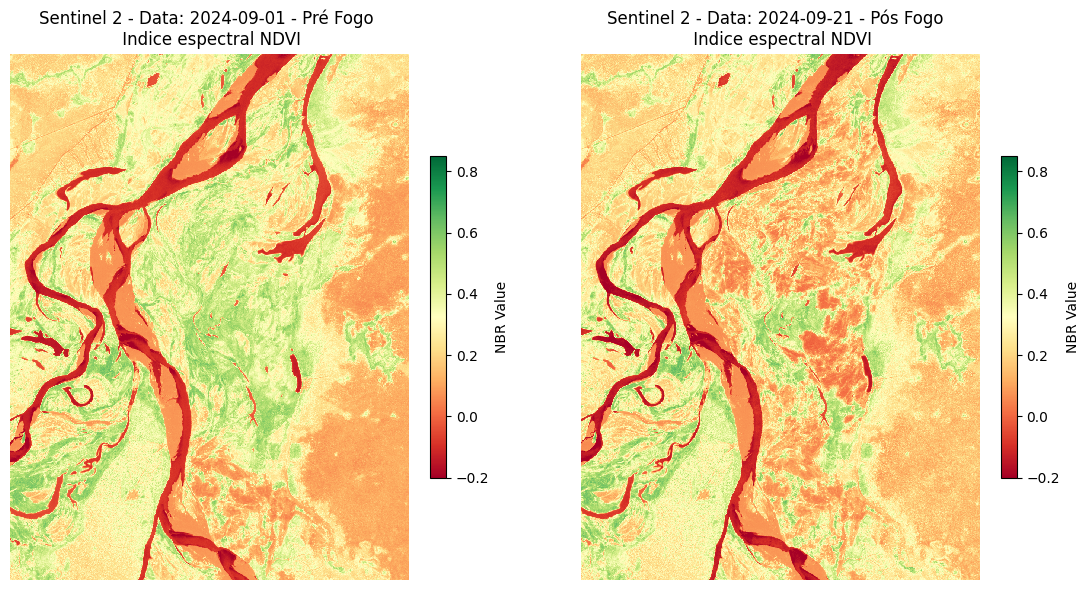

In [808]:
# Configura a figura com dois subplots (1 linha, 2 colunas)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plota imagem NBR pré-fogo
ndvi_pre_plot = axes[0].imshow(ndvi_pre, cmap="RdYlGn", vmin=-0.2, vmax=0.85, interpolation='nearest')
axes[0].set_title(f"Sentinel 2 - Data: {data_pre} - Pré Fogo \n Indice espectral NDVI")
axes[0].axis("off")
cbar_pre = plt.colorbar(ndvi_pre_plot, ax=axes[0], fraction=0.03, pad=0.04)
cbar_pre.set_label("NBR Value")

# Plota imagem NBR pós-fogo
ndvi_pos_plot = axes[1].imshow(ndvi_pos, cmap="RdYlGn", vmin=-0.2, vmax=0.85, interpolation='nearest')
axes[1].set_title(f"Sentinel 2 - Data: {data_pos} - Pós Fogo  \n Indice espectral NDVI")
axes[1].axis("off")
cbar_pos = plt.colorbar(ndvi_pos_plot, ax=axes[1], fraction=0.03, pad=0.04)
cbar_pos.set_label("NBR Value")

# Ajusta o layout para evitar sobreposição
plt.tight_layout()
plt.show()

### Plot Básico - NBR
<hr style="border:1px solid #e69627;">

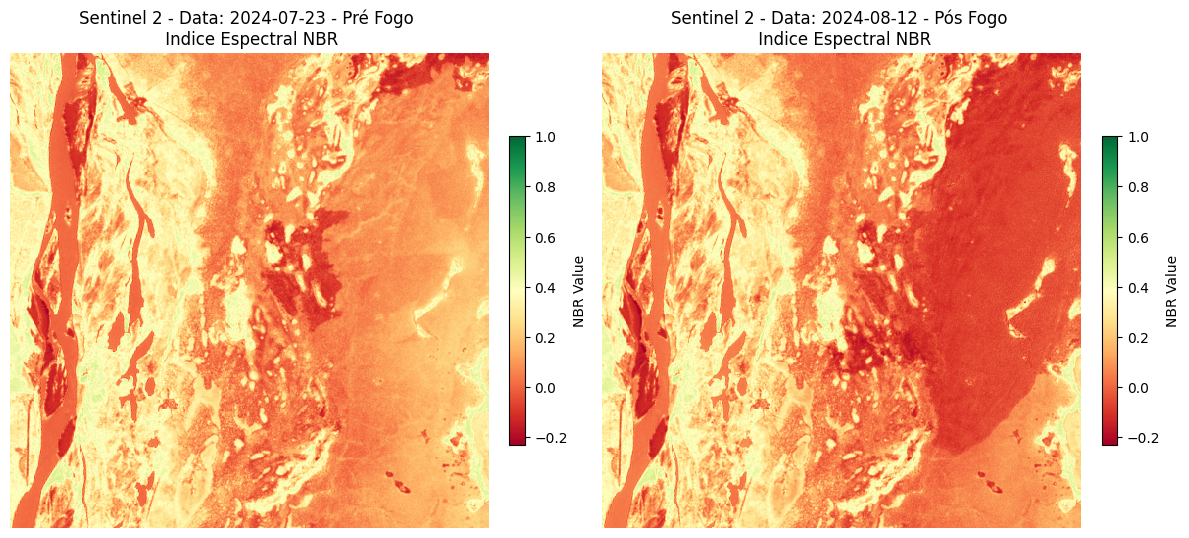

In [23]:
# Configura a figura com dois subplots (1 linha, 2 colunas)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plota imagem NBR pré-fogo
nbr_pre_plot = axes[0].imshow(nbr_pre, cmap="RdYlGn", vmin=-0.23, vmax=1, interpolation='nearest')
axes[0].set_title(f"Sentinel 2 - Data: {data_pre} - Pré Fogo \n Indice Espectral NBR")
axes[0].axis("off")
cbar_pre = plt.colorbar(nbr_pre_plot, ax=axes[0], fraction=0.03, pad=0.04)
cbar_pre.set_label("NBR Value")

# Plota imagem NBR pós-fogo
nbr_pos_plot = axes[1].imshow(nbr_pos, cmap="RdYlGn", vmin=-0.23, vmax=1, interpolation='nearest')
axes[1].set_title(f"Sentinel 2 - Data: {data_pos} - Pós Fogo \n Indice Espectral NBR")
axes[1].axis("off")
cbar_pos = plt.colorbar(nbr_pos_plot, ax=axes[1], fraction=0.03, pad=0.04)
cbar_pos.set_label("NBR Value")

# Ajusta o layout para evitar sobreposição
plt.tight_layout()
plt.show()

### Plot Básico - NBRSWIR
<hr style="border:1px solid #e69627;">

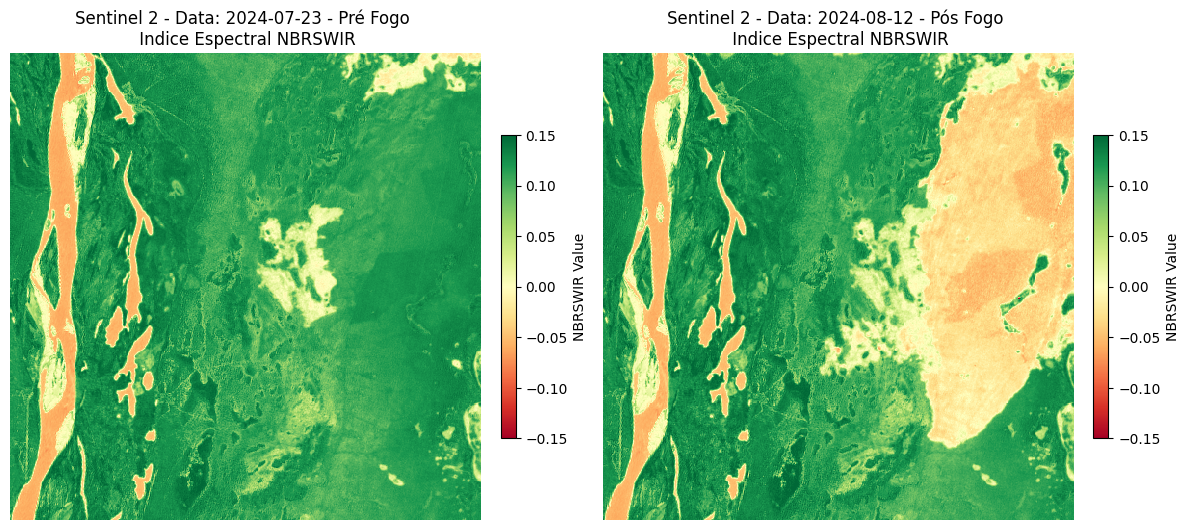

In [24]:
# Configura a figura com dois subplots (1 linha, 2 colunas)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plota imagem NBR pré-fogo
nbrswir_pre_plot = axes[0].imshow(nbrswir_pre, cmap="RdYlGn", vmin=-0.15, vmax=0.15, interpolation='nearest')
axes[0].set_title(f"Sentinel 2 - Data: {data_pre} - Pré Fogo \n Indice Espectral NBRSWIR")
axes[0].axis("off")
cbar_pre = plt.colorbar(nbrswir_pre_plot, ax=axes[0], fraction=0.03, pad=0.04)
cbar_pre.set_label("NBRSWIR Value")

# Plota imagem NBR pós-fogo
nbrswir_pos_plot = axes[1].imshow(nbrswir_pos, cmap="RdYlGn", vmin=-0.15, vmax=0.15, interpolation='nearest')
axes[1].set_title(f"Sentinel 2 - Data: {data_pos} - Pós Fogo \n Indice Espectral NBRSWIR")
axes[1].axis("off")
cbar_pos = plt.colorbar(nbrswir_pos_plot, ax=axes[1], fraction=0.03, pad=0.04)
cbar_pos.set_label("NBRSWIR Value")

# Ajusta o layout para evitar sobreposição
plt.tight_layout()
plt.show()

## Detectando a área queimada com diferença de Índices

### Cálculo da diferença relativa dos índices espectrais das imagens pré-fogo e pós-fogo

In [25]:
# cálculo da diferença relativa dos índices espectrais
ndvi_dif = ndvi_pre - ndvi_pos

nbr_dif = nbr_pre - nbr_pos

nbrswir_dif = nbrswir_pre - nbrswir_pos

In [26]:
print('Apresenta um pequeno recorte de 3 linhas por 3 colunas de dois índices \n')

print('Valores do NDVI pré')
print(ndvi_pre[:3,:3])

print('\n')

print('Valores do NDVI pós')
print(ndvi_pos[:3,:3])

print('\n')

print('Valores de Diferenças do NDVI')
print(ndvi_dif[:3,:3])

Apresenta um pequeno recorte de 3 linhas por 3 colunas de dois índices 

Valores do NDVI pré
[[0.5077166600712306 0.4896022612558045 0.46470227133210557]
 [0.5028248587570621 0.4801762114537445 0.4724455775642283]
 [0.4958793969849246 0.5338907667674792 0.5071161048689139]]


Valores do NDVI pós
[[0.4896418199419167 0.49410422213769495 0.46979607541362056]
 [0.49420127197904967 0.49768303985171447 0.4566882734236889]
 [0.4942528735632184 0.5281211910151489 0.49874596918667136]]


Valores de Diferenças do NDVI
[[0.01807484012931393 -0.004501960881890421 -0.0050938040815149965]
 [0.008623586778012393 -0.017506828397969965 0.015757304140539385]
 [0.0016265234217062163 0.00576957575233028 0.008370135682242541]]


## Plot dos Indices Espectrais:

---

### Diferença de todos os Índices:

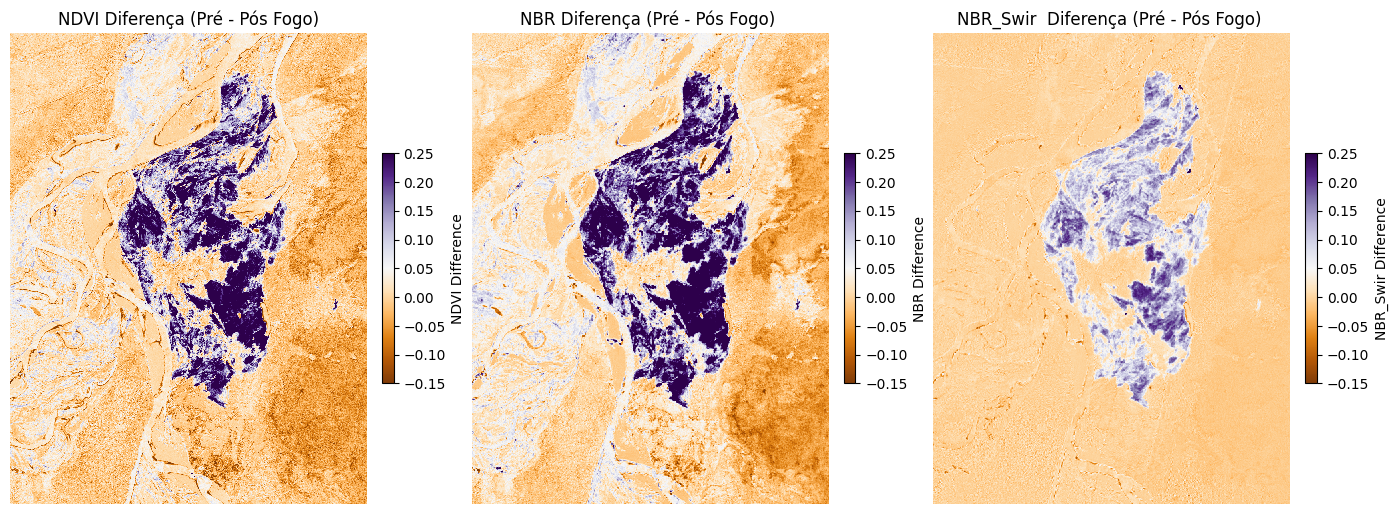

In [813]:
# Configura a figura com dois subplots (1 linha, 3 colunas)
fig, axes = plt.subplots(1, 3, figsize=(14, 10))

# Plota diferença NDVI
ndvi_dif_plot = axes[0].imshow(ndvi_dif, cmap="PuOr", vmin=-0.15, vmax=0.25, interpolation='nearest')
axes[0].set_title("NDVI Diferença (Pré - Pós Fogo)")
axes[0].axis("off")
cbar_ndvi = plt.colorbar(ndvi_dif_plot, ax=axes[0], fraction=0.03, pad=0.04)
cbar_ndvi.set_label("NDVI Difference")

# Plota diferença NBR
nbr_dif_plot = axes[1].imshow(nbr_dif, cmap="PuOr", vmin=-0.15, vmax=0.25, interpolation='nearest')
axes[1].set_title("NBR Diferença (Pré - Pós Fogo) ")
axes[1].axis("off")
cbar_nbr = plt.colorbar(nbr_dif_plot, ax=axes[1], fraction=0.03, pad=0.04)
cbar_nbr.set_label("NBR Difference")

# Plota diferença NBR
nbrswir_dif_plot = axes[2].imshow(nbrswir_dif, cmap="PuOr", vmin=-0.15, vmax=0.25, interpolation='nearest')
axes[2].set_title("NBR_Swir  Diferença (Pré - Pós Fogo) ")
axes[2].axis("off")
cbar_nbr = plt.colorbar(nbrswir_dif_plot, ax=axes[2], fraction=0.03, pad=0.04)
cbar_nbr.set_label("NBR_Swir Difference")

# Ajusta o layout para evitar sobreposição
plt.tight_layout()
plt.show()

### NDVI

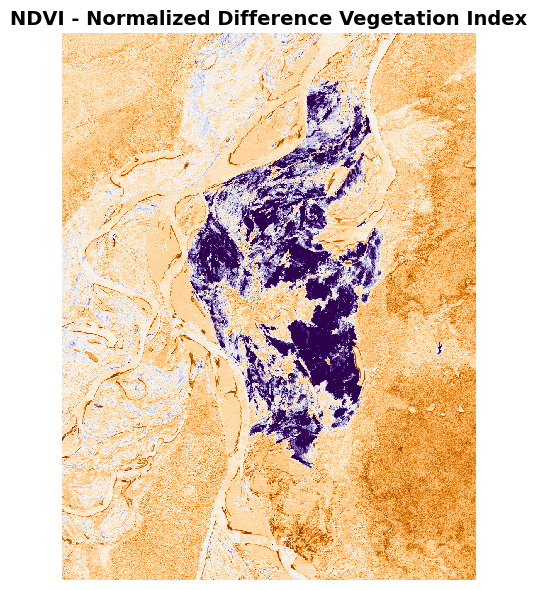

In [814]:
# Cria a figura e o eixo
fig, ax = plt.subplots(figsize=(6, 6))

# Plota diferença NDVI
ndvi_dif_plot = ax.imshow(ndvi_dif, cmap="PuOr", vmin=-0.15, vmax=0.25, interpolation='nearest')
ax.set_title("NDVI - Normalized Difference Vegetation Index", fontsize=14, fontweight='bold')
ax.axis("off")


# Ajusta o layout
plt.tight_layout()
plt.show()


### NBR

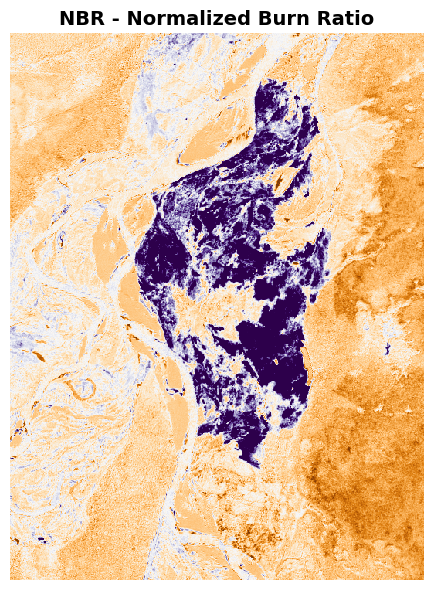

In [815]:
# Cria a figura e o eixo
fig, ax = plt.subplots(figsize=(6, 6))

# Plota diferença NBR
nbr_dif_plot = ax.imshow(nbr_dif, cmap="PuOr", vmin=-0.15, vmax=0.25, interpolation='nearest')
ax.set_title("NBR - Normalized Burn Ratio", fontsize=14, fontweight='bold')
ax.axis("off")

# Ajusta o layout
plt.tight_layout()
plt.show()


### NBR-SWIR

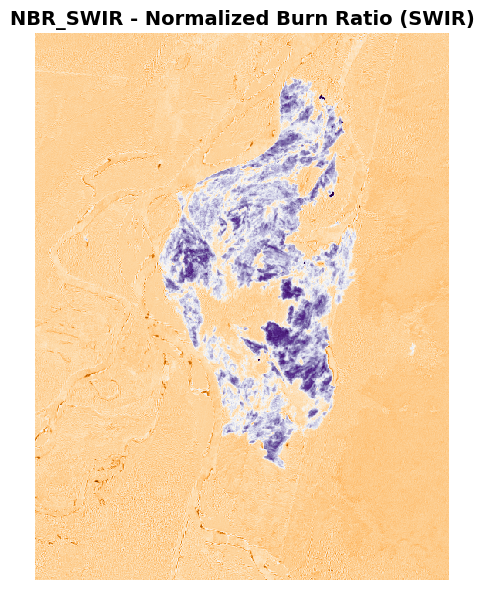

In [816]:
# Cria a figura e o eixo
fig, ax = plt.subplots(figsize=(6, 6))

# Plota diferença NBR_SWIR
nbrswir_dif_plot = ax.imshow(nbrswir_dif, cmap="PuOr", vmin=-0.15, vmax=0.25, interpolation='nearest')
ax.set_title("NBR_SWIR - Normalized Burn Ratio (SWIR)", fontsize=14, fontweight='bold')
ax.axis("off")

# Ajusta o layout
plt.tight_layout()
plt.show()


<br>
<hr>

## Salvando Imagens como Vetores de Diferença:

In [ ]:
# salvar várias de uma vez (compactado)
np.savez_compressed(f"Imagens_e_indices/Image[{linha}]indices_diff.npz",
                    diff_ndvi=ndvi_dif,
                    diff_nbr=nbr_dif,
                    diff_nbrswir=nbrswir_dif)


In [29]:
# Como carregar mais tarde:
data = np.load(f"Imagens_e_indices/Image[{linha}]/Image[{linha}]indices_diff.npz") 
diff_ndvi = data["diff_ndvi"]
diff_nbr  = data["diff_nbr"]